# Assignment 6

### NetID:  ag2422

#### Submission Instructions:

Please fill out this _starter_ Jupyter Notebook, and submit __both__ this `.ipynb` file as well as a pdf file (via html).

 - In the notebook interface, choose `File -> Download as -> Notebook (ipynb)`.
 - In the notebook interface, choose `File -> Download as -> HTML`. Then open the html file, and print to pdf

Notes:

 - We are using the markdown cell-type for texts (and latex), and the code cell-type for the python code. Make sure you don't mix these up. You can change the type from the dropdown at the toolbar on the top.

## -------------------- ##
Below, I import some libraries that I will be using throughout this Problem Set.

In [65]:
import numpy as np
import scipy as sp
import os

## Question 1: Demystifying word2vec

#### Ans (a):
<img src="img_1.jpg">

#### Ans (b)

We have demonstrated in part (a) that the local objective function for a specific $(w,c)$ pair is minimized at the pointwise mutual information (PMI) of $(w_i,w_j)$ [along with a constant $\log(k)$]. Thus if we take $k=1$ and consider the PMI matrix ( which is $|V| \times |V|$ matrix), then we can factor this PMI matrix (using SVD) to recover the word embeddings. Alternatively, if we want to keep k, we can also apply SVD on the matrix 
$$ M = \log \left( \frac{\#(w_i,w_j) \cdot |D|}{\#(w_i) \cdot \#(w_j)} \right) - \log(k) $$

## Question 2: Word Embedding Experiments


In [66]:
import time
from nltk import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
import itertools
import scipy.sparse
import scipy.sparse.linalg
import sklearn.metrics.pairwise

In [67]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

At first, I compute the unigram frequencies using the text8 data corpus.

In [68]:
fdist = Counter()
for rec in open ('/data/text8', 'r'):
    rec = rec.strip()
    fdist.update(word_tokenize(rec))

Now, we construct our vocabulary. To do this:-
* We remove stopwords
* We use a unigram lowerbound of 300

In [69]:
UNIGRAM_LB = 300
sw         = stopwords.words("english")
vocab      = sorted([v for v in fdist.keys() if fdist[v] > UNIGRAM_LB and len(v) >= 3 and v not in sw])
vocab_dict = dict(zip(vocab, range(len(vocab))))
print(len(vocab))

5044


This results in a vocabulary of size 5044 as shown above

In the next two code blocks, I remove words that are not present in the vocabulary and then, compute the cooccurence matrix

In [70]:
partial_word = ''
pruned_text  = []
proc = open('pruned-text8.txt', 'w')
with open('/data/text8', 'r') as f:
    for rec in f:
        rec = rec.strip()
        pruned_text_list = [w for w in rec.split() if w in vocab_dict]
        rec = ' '.join(pruned_text_list)
        pruned_text.append(pruned_text_list)
        proc.write(rec + '\n')
pruned_text = list(itertools.chain.from_iterable(pruned_text))

In [71]:
CONTEXT_SIZE = 5
s            = time.time()
co_s         = sp.sparse.csr_matrix((len(vocab), len(vocab))) # empty matrix

# for sparse matrix construction
d    = []
rows = []
cols = []

for h_idx in range(len(pruned_text)):
    
    l_idx = max(0, h_idx - CONTEXT_SIZE)
    r_idx = min(len(pruned_text)-1, h_idx + CONTEXT_SIZE)

    for l in range(l_idx, h_idx):
        #co[vocab_dict[pruned_text[h_idx]], vocab_dict[pruned_text[l]]] += 1
        rows.append(vocab_dict[pruned_text[h_idx]])
        cols.append(vocab_dict[pruned_text[l]])
        d.append(1)
        
    for r in range(h_idx, r_idx+1):
        #co[vocab_dict[pruned_text[h_idx]], vocab_dict[pruned_text[r]]] += 1
        rows.append(vocab_dict[pruned_text[h_idx]])
        cols.append(vocab_dict[pruned_text[r]])
        d.append(1)
    
    if h_idx % 1000000 == 0 and h_idx != 0:
        #print(h_idx)
        co_s = co_s + sp.sparse.csr_matrix((d, (rows, cols)), shape=(len(vocab), len(vocab)))
        d    = []
        rows = []
        cols = []

if len(d) > 0:
    co_s = co_s + sp.sparse.csr_matrix((d, (rows, cols)), shape=(len(vocab), len(vocab)))

### PMI Embeddings

a) In the following block of code, I calculate the PMI matrix $M_{i,j}$ using the expression given in the problem set:-
$$ M_{i,j} = log\left(\frac{(co_{i,j} + 1.0)*D}{row\_sums[i] * row\_sums[j]}\right)$$

In [72]:
co = co_s.todense() # as addition/multiplication seems difficult in the sparse matrix representation
D = co.sum()  #The sum of all the elements in the co-occuerence matrix
row_sums = co.sum(axis = 1)

M = np.log(((co + 1.0)*D)/(row_sums*(row_sums.T)))

b) Now, we factorize the matrix M by taking the rank-50 SVD using the linalg.svds function from scipy. 

In [73]:
U, s, V = scipy.sparse.linalg.svds(M, k=50)

Scipy just returns the elements of the diagonal in the matrix. We construct the $\Sigma$ matrix below

In [74]:
sigma = np.diag(s)

c) Now we create the vector $W = U\Sigma^{\frac{1}{2}}$

In [75]:
W = np.matmul(U,np.sqrt(sigma))

### Local word2vec Embeddings

Now, using word2vec (from gensim), we construct 100 dimensional embeddings on the text8 data

In [76]:
import gensim
from gensim.models import word2vec
import logging

In [77]:
#turning off some warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentences = word2vec.Text8Corpus('pruned-text8.txt')
model_wv = word2vec.Word2Vec(sentences, size=100, window=10, min_count=10)

### Pre-trained GloVe Embeddings

Now, we load pretrained GloVe embeddings, which were trained on a large corpus containing 6 billion tokens.

In [ ]:
import gensim.downloader as gdl
glove = gdl.load("glove-wiki-gigaword-100")

### Experiments

### Ans(a)

For this, we find the 5 closest words in the embeddings space to the words:-
* Given Words:- yale, physics, republican, einstein, algebra, fish
* My Words:- astronomy, statistics, play, run, dog

#### PMI Embeddings

I calculate the pairwise distance between all the embeddings vectors and store this in the matrix D. Then for each test word, using the vocab_dict function which was written earlier in the PMI embeddings section, I find out the index of the embedding vector of our test matrix. Then using np.argsort, I sort the distances between the embedding vector of the test word and all the other vectors. Finally, I print the top 5 entries of this sorted list to find the 5 words closest to the test word. 

In [82]:
# compute pairwise distances between each embedding vector
D = sklearn.metrics.pairwise.pairwise_distances(W)

test_words = ['yale', 'physics', 'republican', 'einstein', 'algebra', 'fish']
print("Given Words")
for t in test_words:
    print("{}: {}".format(t, [vocab[np.argsort(D[vocab_dict[t],:])[i]] for i in range(1,6)]))
    #code explanation in above block
print("-------------\nMy Words")
test_words = ['astronomy','statistics','play','run','dog']
for t in test_words:
    print("{}: {}".format(t, [vocab[np.argsort(D[vocab_dict[t],:])[i]] for i in range(1,6)]))
     #code explanation in above block

Given Words
yale: ['princeton', 'cornell', 'stanford', 'toronto', 'faculty']
physics: ['mechanics', 'quantum', 'einstein', 'relativity', 'newton']
republican: ['democrats', 'senator', 'presidency', 'candidate', 'presidential']
einstein: ['newton', 'relativity', 'experiment', 'experiments', 'maxwell']
algebra: ['finite', 'theorem', 'algebraic', 'spaces', 'infinite']
fish: ['fruit', 'wild', 'leaves', 'meat', 'trees']
-------------
My Words
astronomy: ['astronomical', 'galileo', 'observation', 'jupiter', 'comet']
statistics: ['statistical', 'survey', 'index', 'estimates', 'ranked']
play: ['playing', 'played', 'players', 'plays', 'score']
run: ['running', 'runs', 'ran', 'start', 'drive']
dog: ['cat', 'bear', 'wild', 'bird', 'dogs']


#### word2vec

Here, I use the most_similar function to find the closest words to our test words. 

In [21]:
print("Given Words")
test_words = ['yale','physics','republican','einstein','algebra','fish']
for j in range(0,len(test_words)):
    a = model_wv.most_similar(positive=test_words[j],topn= 5)
    print(test_words[j],end=": ")
    for i in range(0,len(a)):
        print(a[i][0],end=',')
    print('\n')
        
print("-------------\nMy Words")
test_words = ['astronomy','statistics','play','run','dog']
for j in range(0,len(test_words)):
    a = model_wv.most_similar(positive=test_words[j],topn= 5)
    print(test_words[j],end=": ")
    for i in range(0,len(a)):
        print(a[i][0],end=',')
    print('\n')

Given Words
yale: harvard,princeton,university,cornell,professor,

physics: mechanics,einstein,theoretical,astronomy,chemistry,

republican: democrats,senator,presidential,presidency,conservatives,

einstein: physics,maxwell,relativity,newton,mechanics,

algebra: algebraic,calculus,multiplication,geometric,hilbert,

fish: sheep,feed,fruit,birds,mammals,

-------------
My Words
astronomy: astronomical,physics,observations,mathematics,geology,

statistics: statistical,estimates,census,estimate,bureau,

play: playing,plays,played,players,score,

run: running,runs,ran,drivers,yards,

dog: cat,dogs,bear,breed,bird,



/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  del sys.path[0]


#### GloVe

Here also I use the most_similar function to find the closest words. 

In [22]:
print("Given Words")
test_words = ['yale','physics','republican','einstein','algebra','fish']
for j in range(0,len(test_words)):
    a = glove.most_similar(positive=test_words[j],topn= 5)
    print(test_words[j],end=": ")
    for i in range(0,len(a)):
        print(a[i][0],end=',')
    print('\n')
        
print("-------------\nMy Words")
test_words = ['astronomy','statistics','play','run','dog']
for j in range(0,len(test_words)):
    a = glove.most_similar(positive=test_words[j],topn= 5)
    print(test_words[j],end=": ")
    for i in range(0,len(a)):
        print(a[i][0],end=',')
    print('\n')

2018-11-20 18:01:37,332 : INFO : precomputing L2-norms of word weight vectors


Given Words
yale: harvard,princeton,university,cornell,stanford,

physics: chemistry,mathematics,science,biology,theoretical,

republican: gop,democrat,democratic,republicans,democrats,

einstein: relativity,freud,physics,bohr,theory,

algebra: algebras,geometry,algebraic,boolean,commutative,

fish: shrimp,salmon,tuna,meat,seafood,

-------------
My Words
astronomy: astrophysics,physics,science,mathematics,archaeology,

statistics: figures,report,data,statistic,bureau,

play: playing,played,game,plays,player,

run: running,runs,ran,out,go,

dog: cat,dogs,pet,puppy,horse,



##### Comments on the Closest Embedding Vectors

For all the three different types of embeddings, *the closest vectors all make sense at a broad level*. The closest vectors for all cases are words which are in the same/similar category as that of the given word or a derivative of the same word. Some minute interesting things I noticed are mentioned below:-

<br>

* It's interesting to see how the closest embeddings differ for nouns and verbs. In the case of nouns, the closest 2 embeddings are always other nouns in a similar/same category. (eg. harvard for yale, shrimp for fish). In the case of verbs (for eg. play,run), the top 2 embeddings are different forms of the same verb and not other verbs in the same category. It's not too hard to imagine why this might be happening -- it's obvious that playing is more closely realted to play than game and since nouns don't have different forms, the vectors closest to them are just similar types of nouns.

<br>

* Although the closest embeddings produce similar results, it's still possbile to spot some differences. Since, the GloVe embeddings were trained using a larger corpus compared to the other two trained with the text8 data, they in a sense seem to have access to "finer" word relationships. This is is depicted by the closest vectors to fish and dog. While PMI embeddings and word2vec give words from the same class [eg. for dog we have other animals like cat, beer, bird and for fish we have wild things like sheep, bird, mammals, leaves, trees ], the GloVe embeddings give words which are much more closely realted to fish [eg. shrimp, salmon] and dog[eg. puppy,pet]. Thus due to being trained on a larger corpus, it seems that the GloVe embeddings are slightly superior to the other two embeddings in terms of how related the closest vectors are to the given word

### Ans(b)

In this problem, we use the constructed embeddings to solve a few analogies. 

* Given Analogies:- 
    * france-paris | england - ?
    * france-paris | germany - ?
    * queen-woman | king - ?
    
* My Analogies:-
    * france-paris | india - ?
    * paris-france | london - ? 
    * actress - woman | actor - ?
    * apple - fruit | rose - ?
    * red - stop | green - ?
    
    
#### PMI Embeddings

I define the wordembed Python function to return the word embedding vectors for the word passed on to the function. Then I solve the analogies by constructing vectors as instructed in the question. 

In [35]:
voc_np = np.array(vocab)

def wordembed(str):
    word_idx = np.where(voc_np == str)[0][0]  #alternatively one can use vocab_dict for this as well. 
    return W[word_idx]

In [58]:
vec_1 = wordembed("paris") - wordembed("france") + wordembed("england")
vec_2 = wordembed("paris") - wordembed("france") + wordembed("germany")
vec_3 = wordembed("woman") - wordembed("queen") + wordembed("king")

vec_4 = wordembed("paris") - wordembed("france") + wordembed("india")
vec_5 = wordembed("france") - wordembed("paris") + wordembed("london")
vec_6 = wordembed("woman") - wordembed("actress") + wordembed("actor")
vec_7 = wordembed("fruit") - wordembed("apple") + wordembed("rose")
vec_8 = wordembed("stop") - wordembed("red") + wordembed("green")

vec = [vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8]

I now use Sklearn's parwise_distances function to calculate distances b/w our word embedding vectors and the vectors above.

In [59]:
D_new = sklearn.metrics.pairwise.pairwise_distances(W,Y=vec)

#D_new[:,0] #column 1 --> has distances b/w vec_1 and all our embedding vectors
#D_new[:,1] #Column 2 --> has distances b/w vec_2 and all our embedding vectors

Below we print the words whcih are closest to the vectors in vec using a method very similar to what we used in (a) for PMI embeddings. We calculate the distances between our constructed vector and all other embedding vectors and store it in a matrix called D_new. Then, I srot the distances and print out the words corresponding to the closest 3 embedding vectors  

**To solve the analogy, we choose the first word from the results below which is not present in the analogy.**

##### Comments on the Analogies -- I

To quanitfy performance, for each embedding technique, I will summarize the results of the analogy solutions. I classify something as almost correct, if the correct answer is the 2nd most closest vector (leaving out vectors already in the analogy). After I have quantified performance of all embeddings, I comment at the end on their relative performance.



In [60]:
for i in range(0,len(vec)):
    print("Analogy " + str(i+1), end=": ")
    top_3 = np.argsort(D_new[:,i])[:3]
    for j in range(0,len(top_3)):
        print(vocab[top_3[j]],end=",")
    print("\n")

Analogy 1: england,london,oxford,

Analogy 2: berlin,paris,vienna,

Analogy 3: father,son,woman,

Analogy 4: indian,hindu,egyptian,

Analogy 5: ireland,london,england,

Analogy 6: woman,man,young,

Analogy 7: vegetables,corn,flowers,

Analogy 8: stop,getting,break,



Hence using **PMI embeddings**, we get the analogy solutions as:-

* Given Analogies:- 
    * <font color='green'> france-paris | england - london </font>
    * <font color='green'> france-paris | germany - berlin </font>
    * <font color='red'> queen-woman | king - father </font>
    
* My Analogies:-
    * <font color='red'> france-paris | india - indian </font>
    * <font color='orange'> paris-france | london - ireland </font>
    * <font color='green'> actress - woman | actor - man </font>
    * <font color='red'> apple - fruit | rose - vegetables </font>
    * <font color='red'> red - stop | green - getting </font>
    
    
**<font color='green'> Correct -- 3 </font>  | <font color='orange'>Almost Correct -- 1 </font> | <font color='red'>Incorrect -- 4</font>**

#### word2vec

Here, first I compute the required vectors and then use the most_similar function to find the vectors closest to it. I used the in-built wv function to find the embedding vector corresponding to a word. 

**To solve the analogy, we choose the first word from below which is not present in the analogy.**

In [62]:
vec_1 = model_wv.wv["paris"] - model_wv.wv["france"] + model_wv.wv["england"]
vec_2 = model_wv.wv["paris"] - model_wv.wv["france"] + model_wv.wv["germany"]
vec_3 = model_wv.wv["woman"] - model_wv.wv["queen"] + model_wv.wv["king"]

vec_4 = model_wv.wv["paris"] - model_wv.wv["france"] + model_wv.wv["india"]
vec_5 = model_wv.wv["france"] - model_wv.wv["paris"] + model_wv.wv["london"]
vec_6 = model_wv.wv["woman"] - model_wv.wv["actress"] + model_wv.wv["actor"]
vec_7 = model_wv.wv["fruit"] - model_wv.wv["apple"] + model_wv.wv["rose"]
vec_8 = model_wv.wv["stop"] - model_wv.wv["red"] + model_wv.wv["green"]

vec = [vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8]

In [64]:
for i in range(0,len(vec)):
    print("Analogy " + str(i+1), end=": ")
    a = model_wv.most_similar(positive=[vec[i]],topn= 3)
    for j in range(0,len(a)):
        print(a[j][0],end=",")
    print("\n")

Analogy 1: england,edinburgh,london,

Analogy 2: berlin,munich,germany,

Analogy 3: woman,man,jacob,

Analogy 4: india,indian,beijing,

Analogy 5: london,england,britain,

Analogy 6: woman,man,girl,

Analogy 7: eat,leaves,flowers,

Analogy 8: stop,break,push,



/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/app/venv/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Hence using **word2vec**, we get the analogy solutions as:-

* Given Analogies:- 
    * <font color='orange'> france-paris | england - edinburgh </font>
    * <font color='green'> france-paris | germany - berlin </font>
    * <font color='green'> queen-woman | king - man </font>
    
* My Analogies:-
    * <font color='red'> france-paris | india - indian </font>
    * <font color='orange'> paris-france | london - ireland </font>
    * <font color='green'> actress - woman | actor - man </font>
    * <font color='red'> apple - fruit | rose - eat </font>
    * <font color='red'> red - stop | green - break </font>
    
**<font color='green'> Correct -- 3 </font>  | <font color='orange'>Almost Correct -- 2 </font> | <font color='red'>Incorrect -- 3</font>**

#### GloVe

Here, first I compute the required vectors and then use the most_similar function to find the vectors closest to it. I again used the in-built wv function to find the embedding vector corresponding to a word. 

**To solve the analogy, we choose the first word from below which is not present in the analogy.**

In [ ]:
vec_1 = glove.wv["paris"] - glove.wv["france"] + glove.wv["england"]
vec_2 = glove.wv["paris"] - glove.wv["france"] + glove.wv["germany"]
vec_3 = glove.wv["woman"] - glove.wv["queen"] + glove.wv["king"]

vec_4 = glove.wv["paris"] - glove.wv["france"] + glove.wv["india"]
vec_5 = glove.wv["france"] - glove.wv["paris"] + glove.wv["london"]
vec_6 = glove.wv["woman"] - glove.wv["actress"] + glove.wv["actor"]
vec_7 = glove.wv["fruit"] - glove.wv["apple"] + glove.wv["rose"]
vec_8 = glove.wv["stop"] - glove.wv["red"] + glove.wv["green"]

vec = [vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8]

In [67]:
for i in range(0,len(vec)):
    print("Analogy " + str(i+1), end=": ")
    a = glove.most_similar(positive=[vec[i]],topn= 3)
    for j in range(0,len(a)):
        print(a[j][0],end=",")
    print("\n")

Analogy 1: london,england,melbourne,

Analogy 2: berlin,frankfurt,vienna,

Analogy 3: man,woman,father,

Analogy 4: delhi,mumbai,india,

Analogy 5: britain,england,australia,

Analogy 6: man,woman,person,

Analogy 7: rose,fell,dipped,

Analogy 8: stop,way,going,



Hence using **GloVe embeddings**, we get the analogy solutions as:-

* Given Analogies:- 
    * <font color='green'> france-paris | england - london </font>
    * <font color='green'> france-paris | germany - berlin </font>
    * <font color='green'> queen-woman | king - man </font>
    
* My Analogies:-
    * <font color='green'> france-paris | india - delhi </font>
    * <font color='green'> paris-france | london - britain </font>
    * <font color='green'>actress - woman | actor - man </font>
    * <font color='red'> apple - fruit | rose - fell </font>
    * <font color='orange'> red - stop | green - way </font>
    
**<font color='green'> Correct -- 6 </font>  | <font color='orange'>Almost Correct -- 1 </font> | <font color='red'>Incorrect -- 1</font>**

##### Comments on the Analogies -- II

The GloVe embeddings clearly outperform the PMI Embeddings and word2vec in terms of performance with respecto solving analogies. The reason I think is again that the GloVe emebeddings were trained using a much larger corpus and thus has access to more finer relationships in between more words compared to the other two embeddings. Thus, it can solve the above analogies better than the other two embeddings.  

### Ans (c)

Now, we use tsne to visualize the association/distance between different vectors in the embedding space.

In the function below(which was provided beforehand), nsample is the number of words in the vocabulary that will be sampled. size 1 and size 2 just control the size of the plots and offset controls the text position in the plot. 

In [13]:
%matplotlib notebook

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# this functions computes and displays the 2-d t-SNE maps for a subset of the embedding vectors
# and displays them together with the points for a set of input words.

def display_tsne_neighborhood(model, input_word, nsample=1000, size1=2, size2=10, offset=5):
    
    arr = np.empty((0,100), dtype='f')
    word_label = input_word

    # add the vector for each of the closest words to the array
    for w in range(len(input_word)):
        arr = np.append(arr, np.array([model[input_word[w]]]), axis=0)

    voc = [w for w in model.vocab]
    wrds = np.random.choice(range(len(voc)), size=nsample, replace=False)
    for w in wrds:
        wrd_vector = model[voc[w]]
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coord = Y[:, 0]
    y_coord = Y[:, 1]
    # display scatter plot
    size=2
    plt.scatter(x_coord, y_coord, s=size1)
    plt.scatter(x_coord[0:len(input_word)], y_coord[0:len(input_word)],s=size2)
    
    # label the input words
    for w in range(len(input_word)):
        plt.annotate(input_word[w], xy=(x_coord[w],y_coord[w]), \
                     xytext=(w*offset,w*offset), textcoords='offset points')
    plt.show()
    

Now, we use the function above to find the relative position of different sets of words.

* I use the given words
* I also choose additional sets of words priamrily from the animal kingdom and geopolitics

<IPython.core.display.Javascript object>


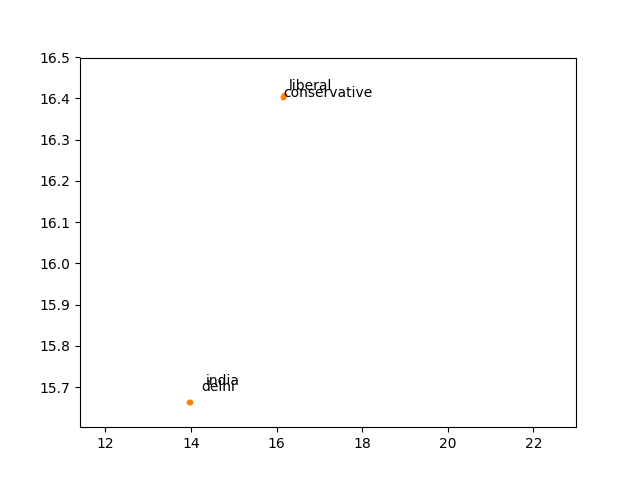

In [54]:
display_tsne_neighborhood(glove, input_word = ['conservative', 'liberal', 'delhi', 'india'],nsample=1500,offset=4)

* For the above visualtization, the results are as expected and the words are clustered according to similarity with each other

<IPython.core.display.Javascript object>


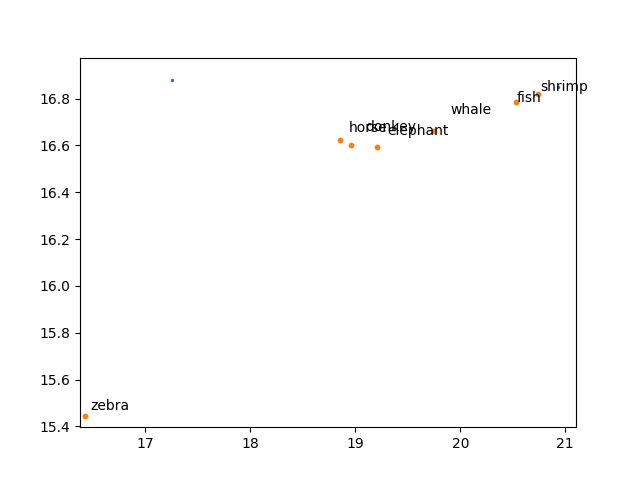

In [60]:
display_tsne_neighborhood(glove, input_word = ['fish','shrimp','zebra','horse','elephant','donkey','whale'],\
                          nsample=1500,offset=2)

For the above clustering, some resutls are expected and some are unexpected:-
* (fish, shrimp), (horse,donkey,elephant) are expected clusterings
* It's wierd that zebra is far away from everything else
* I am also not sure why whale is mid-way between the horse cluster and the fish cluster. Maybe because whale is a mammal, but still water-borne?

<IPython.core.display.Javascript object>


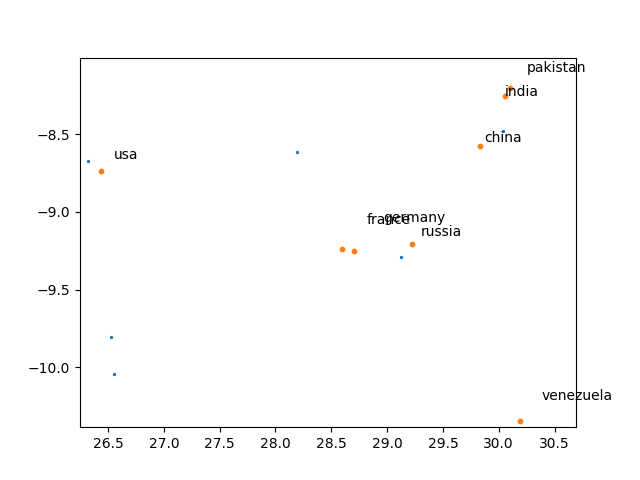

In [61]:
display_tsne_neighborhood(glove, \
                          input_word = ['india','china','russia','usa','pakistan','venezuela','france','germany'],\
                          offset=3, nsample=2000)

Here, I wanted to test how the algorithm culsters countries. I expected the countries to be grouped by geography/political ideology/economy etc. The results are a mixed bag.

* India, Pakistan have a joint history and are close-by geographically. Thus, it's not wierd that they are close to eaach other. China is close georgraphically to these contries and thus it's presence nearby is justified. 

* The France, Germany cluster is also expected due to similar reasons.

* Now Russia is close geographically to all the previous clusters, but on the visualization it's close to france, germany. I am not sure exactly why. Probably because they have more of a shared history.

* It's hard to explain the positions of usa and venezuela. I would have expected them to be much closer considering they are geographically pretty close to each other compared to some of the other countires here.

<IPython.core.display.Javascript object>


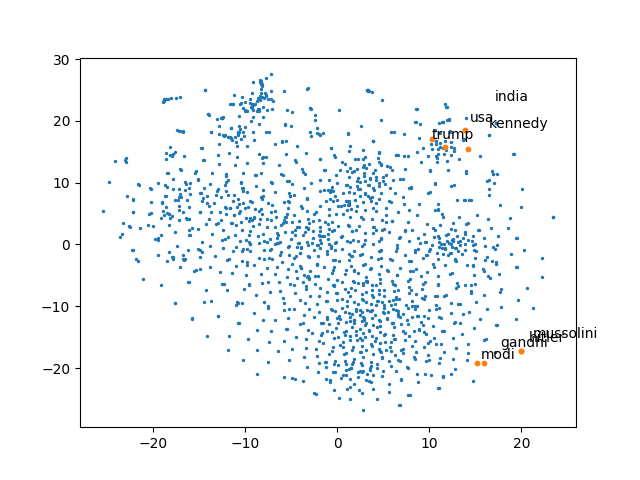

In [62]:
display_tsne_neighborhood(glove, input_word = ['trump','modi','hitler','mussolini','gandhi','kennedy','usa','india']\
                          ,offset=3, nsample=1500)

<img src="zoom_1.png"> <center>Zoomed in section of top image </center>

<img src="zoom2.png"> <center>Zoomed in section of top image </center>

Here, it's a mix of world leaders and countries:-

* The Hitler, Mussolini cluster is expected.
* The Modi, Gandhi cluster is a mixed result. They are indeed leaders from the same country, but with different ideologies. 
* "I am satisfied with the distance between Trump and Kennedy"
* The promixity of the word usa to the leaders is expected.
* Why India is closer to trump and kennedy and much further away from gandhi, modi is hard to explain.

---------------------

The surprising behaviour in some of the visualizations above may be due to reasons below:-

* Words can be clustered using different ways. For eg. one can argue equally well to both why india and china should be clustered as to why india and uk should be clsutered. An embeddings technique may fail to capture all of these different kinds of relationships.

* It's more difficult for an embeddings to find micro-relationships between words. For eg. if meat,tofu,eggs,usa,china,india are visualzied; then any decent embedding will produce two clear clusters with the country names in one cluster and the edible items in another cluster. However, it might fail to produce proper clustering within these sub-categories. Essentially, better performance can be expected when talking about broad, large clusters compared to sub-clusters.

### Question 3: 

#### Artist Embeddings

We now create artist embeddings using word2vec. We do this by using the playlist.txt file, each of line is a list of artists on a particular playlist and thus each line represents some kind of association between the aritists. 

In [29]:
import gensim
from gensim.models import word2vec

playlists = word2vec.LineSentence('playlists.txt')
music_model = word2vec.Word2Vec(playlists, size=64, window=100, min_count=10)

The file artists.txt contains the mapping between the id numbers used in playlists.txt to represent artists and their corresponding names. We build 2 dictionaries id2name and name2id to quickly interchange between artists name and ids.

Finally, we use the in-built most_similar function from gensiom to define the function similar_artists. Given the trained model and aritst name, the function prints the names of the artists corresponding to the 5 closest embedding vectors.

In [30]:
artist = [art.strip() for art in open('artists.txt', 'r')]

id2name = {}
name2id = {}
for w in range(len(artist)):
    id2name["%s" % w] = artist[w]
    name2id[artist[w]] = "%s" % w
    
def similar_artists(model, artist, n=5):
    id = name2id[artist]
    out = model.wv.most_similar(id, topn=n)

    print("Artists similar to %s:" % artist)
    for i in range(n) :
        name = id2name[out[i][0]]
        print(" %s" % name,end=',')
    print("\n------")

#### Ans(a)
 
Now, we find the 5 closest artist embedding vectors to 'The Beatles','Lady Gaga' and 'Nirvana' 

In [31]:
artists = ['The Beatles','Lady Gaga','Nirvana']
for artist in artists:
    similar_artists(music_model,artist)

Artists similar to The Beatles:
 The Kinks, Creedence Clearwater Revival, Grand Funk Railroad, Steppenwolf, The Electric Light Orchestra,
------
Artists similar to Lady Gaga:
 Katy Perry, Bruno Mars, La Roux, Ke$ha, Christina Perri,
------
Artists similar to Nirvana:
 Pearl Jam, A Perfect Circle, Stone Temple Pilots, Everclear, The Red Hot Chili Peppers,
------


/srv/app/venv/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


##### Comment on the closest artists 

Although I am not extremely familiar with all the artist names here, the closest artists to each of The Beatles, Lady Gaga and Nirvana do make sense in that broadly speaking, at a high level, they made similar kinds of music/music of the same genre/were contemporary artists. 

#### Ans(b)

Now, we use tsne to visualize the association/distance between different vectors in the embedding space.

In the function below(which was provided beforehand), nsample is the number of words in the vocabulary that will be sampled. size 1 and size 2 just control the size of the plots and offset controls the text position in the plot. 

In [34]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# this functions computes and displays the 2-d t-SNE maps for a subset of the embedding vectors
# and displays them together with the points for a set of input words.

def display_tsne_artists(model, artists, nsample=1000, size1=2, size2=10, offset=5):
    
    arr = np.empty((0,64), dtype='f')

    # add the vector for each of the closest words to the array
    for a in range(len(artists)):
        id = name2id[artists[a]]
        arr = np.append(arr, np.array([model[id]]), axis=0)

    voc = [w for w in model.wv.vocab]
    ids = np.random.choice(range(len(voc)), size=nsample, replace=False)
    for w in ids:
        wrd_vector = model[voc[w]]
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coord = Y[:, 0]
    y_coord = Y[:, 1]
    # display scatter plot
    size=2
    plt.scatter(x_coord, y_coord, s=size1)
    plt.scatter(x_coord[0:len(artists)], y_coord[0:len(artists)],s=size2)
    
    # label the input words
    for w in range(len(artists)):
        plt.annotate(artists[w], xy=(x_coord[w],y_coord[w]), \
                     xytext=(w*offset,w*offset), textcoords='offset points')
    plt.show()

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


<IPython.core.display.Javascript object>


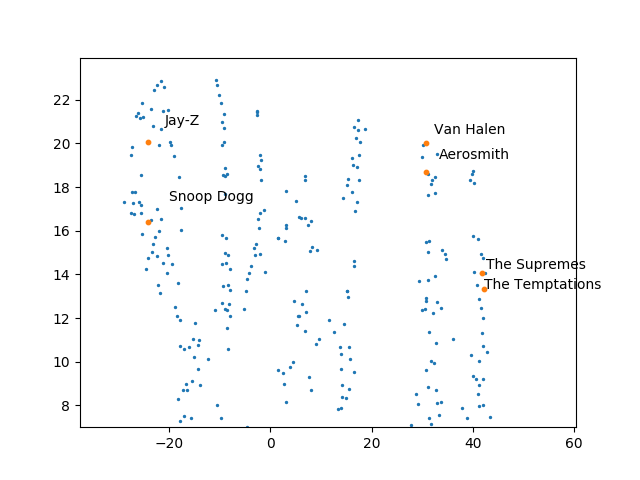

In [47]:
display_tsne_artists(music_model, \
                     ['The Temptations', 'The Supremes', 'Van Halen', 'Aerosmith', 'Jay-Z', 'Snoop Dogg'], \
                     nsample=1000, offset=3)

Here the visualization makes senese. Again the clustering is by similar kinds of music/music of the same genre/were contemporary artists. 

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


<IPython.core.display.Javascript object>


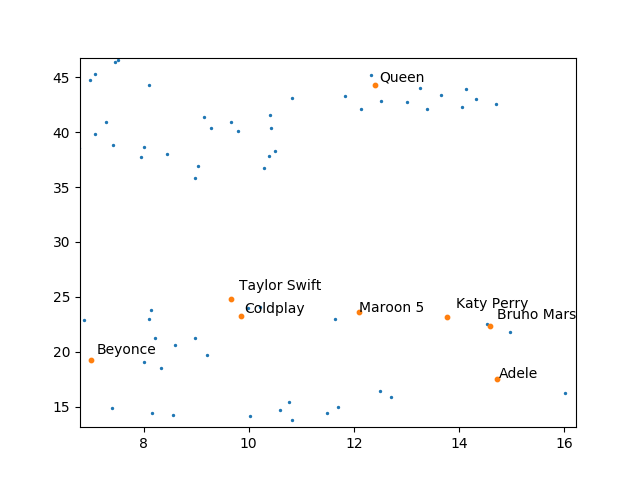

In [49]:
display_tsne_artists(music_model, ['Maroon 5', 'Adele','Coldplay','Queen','Beyonce','Bruno Mars','Taylor Swift',\
                                   'Katy Perry'],nsample=1000, offset=1)

Here, the results are a mixed bag:-

   * It's expected that Queen is far-away from the other contemporary names. 
   * Taylor Swift, Coldplay,Maroon 5, Katy Perry, Bruno Mars all are from the pop genre and hence it's not unexpected that they are close together.
   * Although I expeced to see a closer relationship between Maroon 5 and Coldplay given that both of these are all boy bands singing similar music.
   * It's expected that Adele and Beyonce are a bit away from the above artists as they sing slightly different kinds of music. However, the distance between Adele and Beyonce is a bit hard to explain for me. 